# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.357083,True,9.125432
1,1.083218,True,8.333562
2,-1.405914,True,0.612934
3,0.544866,True,7.162384
4,0.678475,True,5.906530
...,...,...,...
995,1.141585,False,1.742434
996,1.448861,True,9.645512
997,-1.180041,False,-2.199560
998,0.331246,True,4.966359


<Axes: xlabel='v0'>

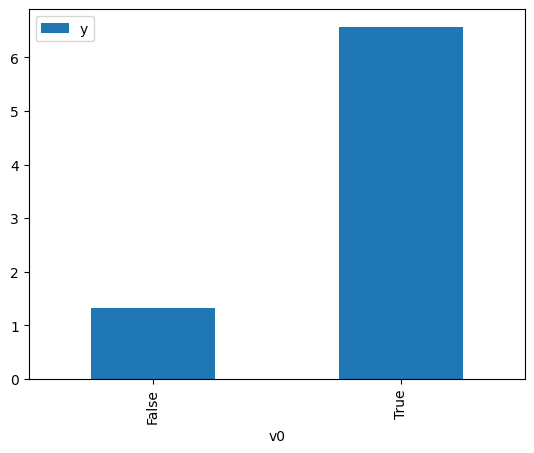

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

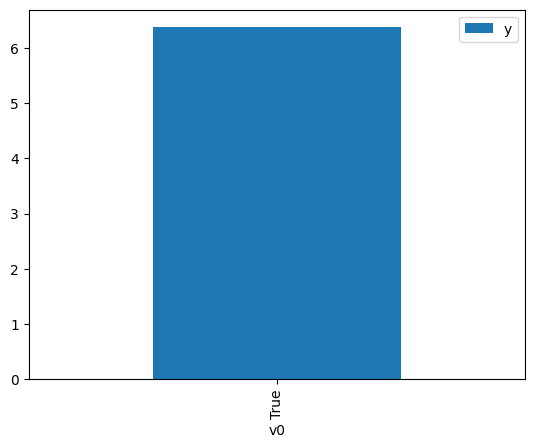

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.863823,False,5.043438,0.341879,2.925007
1,-0.942918,False,-3.132091,0.628782,1.590376
2,2.051547,False,5.045559,0.324322,3.083357
3,0.272542,False,1.963705,0.503791,1.984952
4,-0.626944,False,-2.131502,0.597230,1.674395
...,...,...,...,...,...
995,0.274917,False,1.188372,0.503541,1.985937
996,2.142835,False,3.724875,0.315955,3.165004
997,1.085725,False,1.130440,0.418905,2.387177
998,1.057579,False,3.510709,0.421793,2.370833


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.700487,True,6.066825,0.541168,1.847855
1,3.784091,True,12.722615,0.812076,1.231411
2,-0.491960,True,6.804122,0.416515,2.400874
3,2.036653,True,10.598381,0.674302,1.483014
4,0.350898,True,6.921556,0.504458,1.982325
...,...,...,...,...,...
995,-0.334890,True,5.265809,0.432673,2.311215
996,0.624873,True,8.145840,0.533252,1.875286
997,-0.635418,True,2.679304,0.401911,2.488111
998,1.072236,True,8.313301,0.579712,1.724995


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          1.425e+04
Date:                Fri, 22 Nov 2024   Prob (F-statistic):                        0.00
Time:                        16:01:30   Log-Likelihood:                         -1453.3
No. Observations:                1000   AIC:                                      2911.
Df Residuals:                     998   BIC:                                      2920.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4043      0.033     73.345      0.000       2.340       2.469
x2             5.0004      0.052     96.720      0.000       4.899       5.102
==============================================================================
Omnibus:                        0.868   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.648   Jarque-Bera (JB):                0.742
Skew:                           0.003   Prob(JB):                        0.690
Kurtosis:                       3.133   Cond. No.                         2.05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""